In [93]:
# %pip install pandas
# %pip install numpy
# %pip install matplotlib
# %pip install scikit-learn
# %pip install tensorflow

In [94]:
import numpy as np
import pandas as pd

## Spike detection

In [95]:
from datetime import datetime

#Formatting the date and price for Volza data
volza_pd = pd.read_csv("../volza/magnesium/magnesium.csv")
volza_pd = volza_pd[(volza_pd["Country of Origin"].notnull()) & (volza_pd["Country of Destination"].notnull())]
volza_pd = volza_pd.rename(columns={'Unnamed: 0': 'ID'})
volza_pd['Date'] = volza_pd['Date'].apply(lambda x: x.split(' ')[0])
volza_pd['Date'] = pd.to_datetime(volza_pd['Date'], errors='raise', format='%Y-%m-%d')

In [96]:
#Preprocessing the price data
prices_pd = pd.read_csv("../volza/magnesium/magnesium_price_2.csv")
prices_pd['Date'] = prices_pd['Date'].apply(lambda x: datetime.strptime(x, "%b %d, %Y").strftime("%Y-%m-%d"))
prices_pd['Date'] = pd.to_datetime(prices_pd['Date'], errors='raise', format='%Y-%m-%d')
prices_pd['Price'] = prices_pd['Price'].str.replace(',', '').astype(float)
prices_pd = prices_pd[['Date','Price']]

In [97]:
#Aggregate volza data by day
date_wise_volza = volza_pd.groupby("Date")[['Value','Quantity','Gross Weight']].sum()

In [98]:
prices_pd = prices_pd.set_index('Date')
aggregated_df = date_wise_volza.join(prices_pd, how="left").fillna(method='ffill')

In [99]:
## Detecting spikes
window_size = 20  # Adjust the window size based on your data
moving_avg = aggregated_df['Price'].rolling(window=window_size).mean()
std_dev = aggregated_df['Price'].rolling(window=window_size).std()

# Set a threshold to identify spikes
threshold = 2  # You can adjust this value based on your data
spikes = (abs(aggregated_df['Price'] - moving_avg) > threshold * std_dev)
aggregated_df['spikes'] = (abs(aggregated_df['Price'] - moving_avg) > threshold * std_dev).astype(int)

In [100]:
#remove date 2020-01-01
aggregated_df = aggregated_df[aggregated_df.index != '2020-01-01']
aggregated_df

,Value,Quantity,Gross Weight,Price,spikes
Date,,,,,
2020-01-02,1.125000e+05,50040.00,89356.0,14150.0,0
2020-01-03,8.744076e+05,50222.26,25040.0,14100.0,0
2020-01-04,3.029376e+05,110028.00,0.0,14100.0,0
2020-01-05,4.420000e+04,20000.00,0.0,14100.0,0
2020-01-06,1.780024e+04,5001.00,2218.5,14100.0,0
...,...,...,...,...,...
2022-12-27,9.624998e+04,25180.00,250400.0,21700.0,0
2022-12-28,1.122651e+06,286996.89,80306.0,21650.0,0
2022-12-29,1.303649e+06,306928.00,0.0,21650.0,0


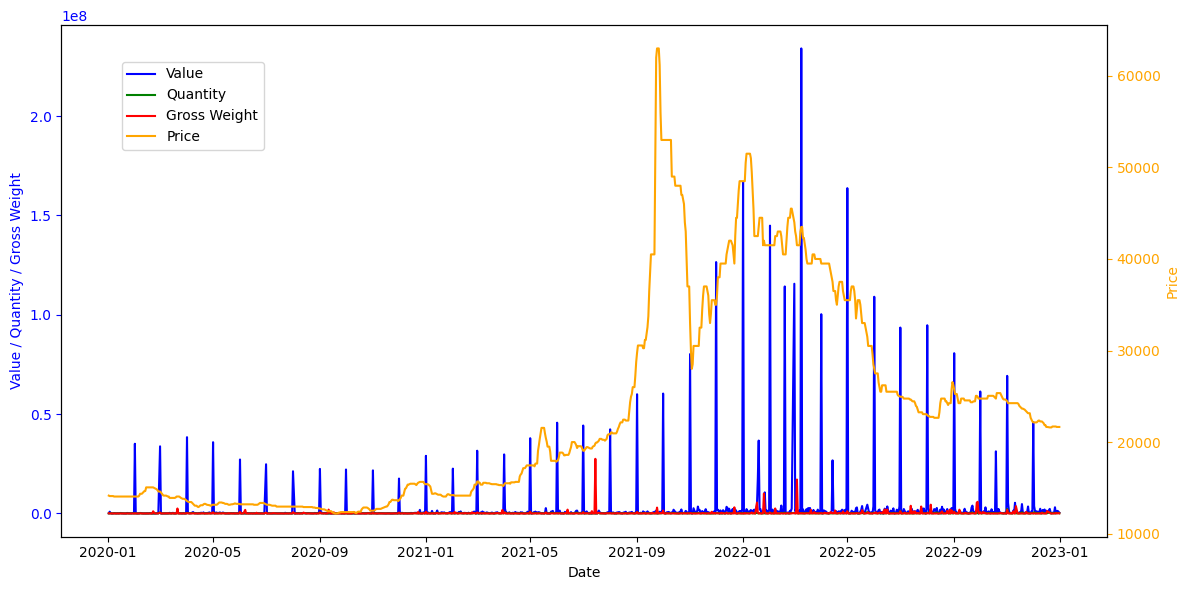

In [101]:
#Visualise Dataset

import matplotlib.pyplot as plt
# Plotting the graph
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plotting 'Value', 'Quantity', and 'Gross Weight' on the left y-axis
ax1.plot(aggregated_df.index, aggregated_df['Value'], label='Value', color='b')
ax1.plot(aggregated_df.index, aggregated_df['Quantity'], label='Quantity', color='g')
ax1.plot(aggregated_df.index, aggregated_df['Gross Weight'], label='Gross Weight', color='r')

ax1.set_xlabel('Date')
ax1.set_ylabel('Value / Quantity / Gross Weight', color='b')
ax1.tick_params('y', colors='b')

# Creating a second y-axis for 'Price'
ax2 = ax1.twinx()
ax2.plot(aggregated_df.index, aggregated_df['Price'], label='Price', color='orange')
ax2.set_ylabel('Price', color='orange')
ax2.tick_params('y', colors='orange')

# Display legend
fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

# Display the graph
plt.show()

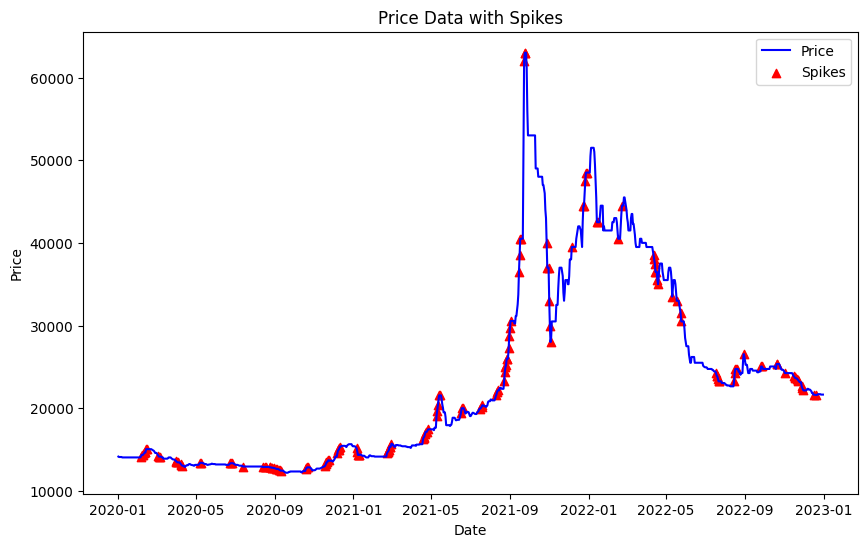

In [102]:
# Plotting the price data
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.plot(aggregated_df.index, aggregated_df['Price'], label='Price', color='blue')

# Highlighting spikes
spike_indices = aggregated_df[aggregated_df['spikes'] == 1].index
spike_prices = aggregated_df.loc[spike_indices, 'Price']
plt.scatter(spike_indices, spike_prices, color='red', marker='^', label='Spikes')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Price Data with Spikes')
plt.legend()

# Display the plot
plt.show()

## Data Prep for Classification

In [103]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

time_series_df = aggregated_df.copy()
# Assuming 'time_series_df' is your DataFrame

# Drop rows with NaN in the 'spikes' column
time_series_df = time_series_df.dropna(subset=['spikes'])

# Extract features and target variable
X = time_series_df[['Value', 'Quantity', 'Gross Weight', 'Price']].values
y = time_series_df['spikes'].values

# Feature scaling using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create sequences for each sample with a window size of 20
window_size = 20
X_sequences, y_sequences = [], []

for i in range(len(X_scaled) - window_size + 1):
    X_sequences.append(X_scaled[i:i + window_size, :])
    y_sequences.append(y[i + window_size - 1])

X_sequences, y_sequences = np.array(X_sequences), np.array(y_sequences)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_sequences, y_sequences, test_size=0.2, random_state=50)

In [104]:
def make_output_dict(name, params, classification_report):
    return {
        "name": name,
        "params": params,
        "accuracy": classification_report["accuracy"],
        "precision (0)": classification_report["0"]["precision"],
        "recall (0)": classification_report["0"]["recall"],
        "f1 (0)": classification_report["0"]["f1-score"],
        "precision (1)": classification_report["1"]["precision"],
        "recall (1)": classification_report["1"]["recall"],
        "f1 (1)": classification_report["1"]["f1-score"],
    }

output_dicts = []

In [105]:
#LSTM Model
def evaluate_lstm(num_layers: int):
  # Build the LSTM model
  model = Sequential()
  model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()])

  # Train the model
  model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=False)


  y_pred = (model.predict(X_test) > 0.5).astype(int)


  # Generate confusion matrix
  # conf_matrix = confusion_matrix(y_test, y_pred)

  # # Calculate accuracy
  # accuracy = accuracy_score(y_test, y_pred)

  # Display confusion matrix
  # plt.figure(figsize=(6, 6))
  # sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
  #             xticklabels=['No Spike', 'Spike'], yticklabels=['No Spike', 'Spike'])
  # plt.xlabel('Predicted')
  # plt.ylabel('Actual')
  # plt.title(f'Confusion Matrix\nAccuracy: {accuracy * 100:.2f}%')
  # plt.show()

  return make_output_dict(f"LSTM", f"{num_layers} layers", classification_report(y_test, y_pred, output_dict=True))


## LSTM (100 layers)

In [106]:
#LSTM Model

output_dicts.append(evaluate_lstm(250))
output_dicts.append(evaluate_lstm(200))
output_dicts.append(evaluate_lstm(100))
output_dicts.append(evaluate_lstm(50))

# Build the LSTM model
# model = Sequential()
# model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
# model.add(Dense(1, activation='sigmoid'))
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()])

# # Train the model
# print(X_train.shape)
# model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=False)


# y_pred = (model.predict(X_test) > 0.5).astype(int)


# # Generate confusion matrix
# conf_matrix = confusion_matrix(y_test, y_pred)

# # Calculate accuracy
# accuracy = accuracy_score(y_test, y_pred)
# output_dicts.append(make_output_dict("LSTM (100 layers)", "", classification_report(y_test, y_pred, output_dict=True)))

# # Display confusion matrix
# plt.figure(figsize=(6, 6))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
#             xticklabels=['No Spike', 'Spike'], yticklabels=['No Spike', 'Spike'])
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title(f'Confusion Matrix\nAccuracy: {accuracy * 100:.2f}%')
# plt.show()


7/7 [==============================] - 0s 5ms/step


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np


def evaluate_random_forest(n_estimators):
  # Create a Random Forest Classifier
  random_forest = RandomForestClassifier(n_estimators=10, random_state=213)

  X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
  X_test_reshaped = X_test.reshape(X_test.shape[0], -1)

  # Train the classifier
  random_forest.fit(X_train_reshaped, y_train)

  # Make predictions on the test set
  y_pred = random_forest.predict(X_test_reshaped)

  # Generate confusion matrix
  # conf_matrix = confusion_matrix(y_test, y_pred)

  # # Calculate accuracy
  # accuracy = accuracy_score(y_test, y_pred)
  return make_output_dict("Random Forest", f"{n_estimators} Estimators", classification_report(y_test, y_pred, output_dict=True))

  # Display confusion matrix
  # plt.figure(figsize=(6, 6))
  # sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
  #             xticklabels=['No Spike', 'Spike'], yticklabels=['No Spike', 'Spike'])
  # plt.xlabel('Predicted')
  # plt.ylabel('Actual')
  # plt.title(f'Confusion Matrix\nAccuracy: {accuracy * 100:.2f}%')
  # plt.show()


## Random Forrest Classifier

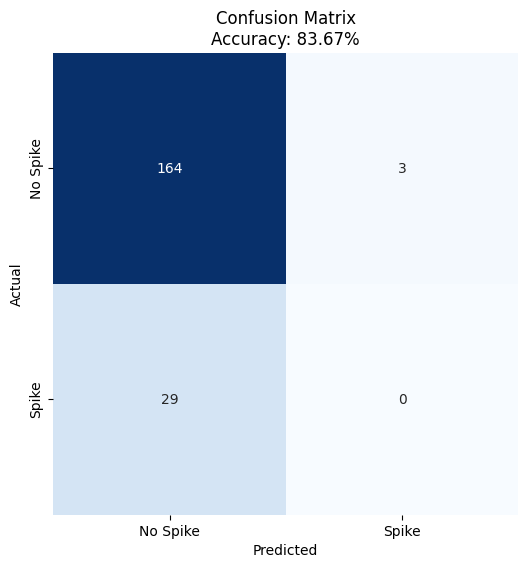

In [ ]:
output_dicts.append(evaluate_random_forest(50))
output_dicts.append(evaluate_random_forest(25))
output_dicts.append(evaluate_random_forest(20))
output_dicts.append(evaluate_random_forest(10))
output_dicts.append(evaluate_random_forest(5))

# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score, classification_report
# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import train_test_split
# import numpy as np

# # Create a Random Forest Classifier
# random_forest = RandomForestClassifier(n_estimators=10, random_state=213)

# X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
# X_test_reshaped = X_test.reshape(X_test.shape[0], -1)

# # Train the classifier
# random_forest.fit(X_train_reshaped, y_train)

# # Make predictions on the test set
# y_pred = random_forest.predict(X_test_reshaped)

# # Generate confusion matrix
# conf_matrix = confusion_matrix(y_test, y_pred)

# # Calculate accuracy
# accuracy = accuracy_score(y_test, y_pred)
# output_dicts.append(make_output_dict("Random Forest", f"", classification_report(y_test, y_pred, output_dict=True)))

# # Display confusion matrix
# plt.figure(figsize=(6, 6))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
#             xticklabels=['No Spike', 'Spike'], yticklabels=['No Spike', 'Spike'])
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title(f'Confusion Matrix\nAccuracy: {accuracy * 100:.2f}%')
# plt.show()


In [ ]:
output_dicts = pd.DataFrame(output_dicts)
output_dicts

,name,params,accuracy,precision (0),recall (0),f1 (0),precision (1),recall (1),f1 (1)
0,LSTM (100 layers),,0.892857,0.934524,0.940120,0.937313,0.642857,0.620690,0.631579
1,LSTM (50 layers),,0.872449,0.912791,0.940120,0.926254,0.583333,0.482759,0.528302
2,LSTM (20 layers),,0.846939,0.900585,0.922156,0.911243,0.480000,0.413793,0.444444
3,LSTM (10 layers),,0.857143,0.901734,0.934132,0.917647,0.521739,0.413793,0.461538
4,LSTM (5 layers),,0.857143,0.921212,0.910180,0.915663,0.516129,0.551724,0.533333
5,Random Forest,,0.836735,0.849741,0.982036,0.911111,0.000000,0.000000,0.000000


## OEC Trade Data

In [ ]:
# oed_data = spark.read.csv("/Users/harshdeepsingh/Downloads/trade_i_baci_a_12.tsv", header=True, sep="\t")

In [ ]:
# oed_data.printSchema()
# magnesium_data = oed_data.filter(col("hs_code").like("8104%"))

In [ ]:
# exported_mag_data = oed_data.groupBy("year","exporter_name").agg(F.sum("value").alias("export_value"),F.sum("quantity").alias("export_quantity"))

In [ ]:
# temp = exported_mag_data.withColumn("mag_price_calc", col("export_value")/col("export_quantity")).orderBy("year")

In [ ]:
# temp.filter("exporter_name == 'China'").show()